In [1]:
# Cell 1 - Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 5)


In [2]:
# Cell 2 - Read CSV
df = pd.read_csv('Xiaomi_clean.csv')   # đảm bảo file nằm cùng thư mục notebook
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-09,16.6,17.000000,16.000000,16.799999,16.799999,462182642
1,2018-07-10,17.0,19.340000,17.000000,19.000000,19.000000,534072218
2,2018-07-11,18.5,19.799999,18.299999,19.000000,19.000000,374721138
3,2018-07-12,19.4,19.700001,19.020000,19.260000,19.260000,132592630
4,2018-07-13,19.6,21.799999,19.520000,21.450001,21.450001,364065075


In [3]:
# Cell 3 - Quick info
print(df.columns)
df.info()


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1800 non-null   object 
 1   Open       1800 non-null   float64
 2   High       1800 non-null   float64
 3   Low        1800 non-null   float64
 4   Close      1800 non-null   float64
 5   Adj Close  1800 non-null   float64
 6   Volume     1800 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 98.6+ KB


In [4]:
# Cell 4 - Convert Date to datetime and set index
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df.set_index('Date', inplace=True)
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-09,16.6,17.000000,16.000000,16.799999,16.799999,462182642
2018-07-10,17.0,19.340000,17.000000,19.000000,19.000000,534072218
2018-07-11,18.5,19.799999,18.299999,19.000000,19.000000,374721138
2018-07-12,19.4,19.700001,19.020000,19.260000,19.260000,132592630
2018-07-13,19.6,21.799999,19.520000,21.450001,21.450001,364065075


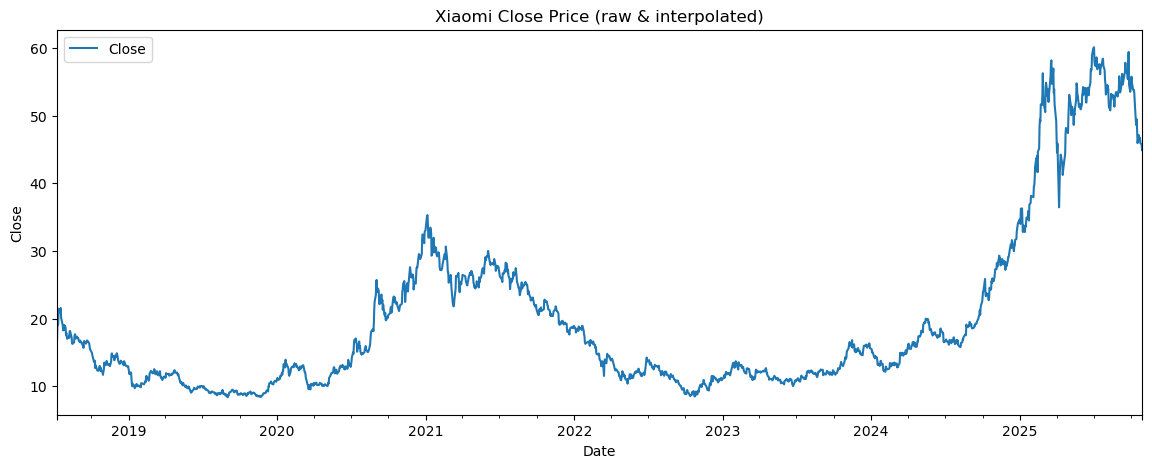

In [5]:
# Cell 5 - Select Close column and ensure daily frequency (interpolate if missing)
df_close = df[['Close']].copy()

# Optionally enforce daily freq and interpolate missing days (keeps consistent plotting)
df_close = df_close.asfreq('D')        # gán tần suất hàng ngày
df_close = df_close.interpolate()      # nội suy các giá trị missing nếu có

df_close.plot(title='Xiaomi Close Price (raw & interpolated)')
plt.ylabel('Close')
plt.show()


In [6]:
# Cell 6 - Normalization using MinMaxScaler (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_close)   # kết quả là array (n,1)
data_scaled = data_scaled.reshape(-1)          # 1D array of scaled close values


In [7]:
# Cell 7 - Split data
n = len(data_scaled)
train_size = int(0.6 * n)
val_size = int(0.2 * n)
test_size = n - train_size - val_size

train_data = data_scaled[:train_size]
val_data = data_scaled[train_size: train_size + val_size]
test_data = data_scaled[train_size + val_size :]

print("Total:", n, "Train:", len(train_data), "Val:", len(val_data), "Test:", len(test_data))


Total: 2669 Train: 1601 Val: 533 Test: 535


In [8]:
# Cell 8 - Init variables for grid search
best_alpha = None
best_mse = float('inf')
best_mape = None
best_rmse = None
best_msle = None
best_y_pred_val = None


In [9]:
# Cell 9 - Grid search over alpha (0.1 to 1.0 step 0.1)
alphas = np.round(np.arange(0.1, 1.01, 0.1), 2)

for alpha in alphas:
    alpha = float(np.round(alpha, 2))
    history = list(train_data.copy())   # history holds scaled values
    y_pred_val = []
    
    # rolling one-step forecast on validation set
    for obs in val_data:
        # build SES on current history
        model = SimpleExpSmoothing(history, initialization_method='estimated')
        fit = model.fit(smoothing_level=alpha, optimized=False)
        pred = fit.forecast(1)[0]
        y_pred_val.append(pred)
        # append actual observation to history (rolling)
        history.append(obs)
    
    # inverse scale to compute metrics on original scale
    val_true_inv = scaler.inverse_transform(np.array(val_data).reshape(-1,1)).reshape(-1)
    y_pred_val_inv = scaler.inverse_transform(np.array(y_pred_val).reshape(-1,1)).reshape(-1)
    
    mse = mean_squared_error(val_true_inv, y_pred_val_inv)
    mape = mean_absolute_percentage_error(val_true_inv, y_pred_val_inv)
    rmse = np.sqrt(mse)
    # msle needs non-negative, close prices are non-negative
    msle = mean_squared_log_error(val_true_inv, y_pred_val_inv)
    
    # update best
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_mape = mape
        best_rmse = rmse
        best_msle = msle
        best_y_pred_val = y_pred_val_inv

    print(f"alpha={alpha:.2f} -> MSE={mse:.4f}, MAPE={mape:.6f}, RMSE={rmse:.4f}")
    
print("\nBest alpha:", best_alpha)
print("Best validation metrics: MSE:", best_mse, "MAPE:", best_mape, "RMSE:", best_rmse, "MSLE:", best_msle)


alpha=0.10 -> MSE=0.3655, MAPE=0.035322, RMSE=0.6046
alpha=0.20 -> MSE=0.1872, MAPE=0.025340, RMSE=0.4327
alpha=0.30 -> MSE=0.1315, MAPE=0.020973, RMSE=0.3627
alpha=0.40 -> MSE=0.1047, MAPE=0.018362, RMSE=0.3236
alpha=0.50 -> MSE=0.0893, MAPE=0.016644, RMSE=0.2988
alpha=0.60 -> MSE=0.0797, MAPE=0.015457, RMSE=0.2823
alpha=0.70 -> MSE=0.0736, MAPE=0.014541, RMSE=0.2713
alpha=0.80 -> MSE=0.0698, MAPE=0.013886, RMSE=0.2642
alpha=0.90 -> MSE=0.0677, MAPE=0.013496, RMSE=0.2603
alpha=1.00 -> MSE=0.0672, MAPE=0.013343, RMSE=0.2592

Best alpha: 1.0
Best validation metrics: MSE: 0.06719058118276022 MAPE: 0.013342525633085777 RMSE: 0.25921146036153614 MSLE: 0.00033160890254981245


In [10]:
# Cell 10 - Summary of best alpha and sample compare (first 10 preds)
print("Best alpha:", best_alpha)
print("Validation MSE (best):", best_mse)
print("Validation MAPE (best):", best_mape)
print("Validation RMSE (best):", best_rmse)
print("Validation MSLE (best):", best_msle)

# show few predicted vs actual for validation
val_index = df_close.index[train_size: train_size + val_size]
pd.DataFrame({
    'Date': val_index[:10],
    'Actual_Close': scaler.inverse_transform(val_data[:10].reshape(-1,1)).reshape(-1),
    'Pred_Close': best_y_pred_val[:10]
})


Best alpha: 1.0
Validation MSE (best): 0.06719058118276022
Validation MAPE (best): 0.013342525633085777
Validation RMSE (best): 0.25921146036153614
Validation MSLE (best): 0.00033160890254981245


,Date,Actual_Close,Pred_Close
0,2022-11-26,9.44,9.49
1,2022-11-27,9.39,9.44
2,2022-11-28,9.34,9.39
3,2022-11-29,9.97,9.34
4,2022-11-30,10.32,9.97
5,2022-12-01,10.46,10.32
6,2022-12-02,10.12,10.46
7,2022-12-03,10.58,10.12
8,2022-12-04,11.04,10.58
9,2022-12-05,11.50,11.04


In [11]:
# Cell 11 - Test rolling forecasting using best_alpha
history = list(np.concatenate([train_data, val_data]))
y_pred_test = []

for obs in test_data:
    model = SimpleExpSmoothing(history, initialization_method='estimated')
    fit = model.fit(smoothing_level=best_alpha, optimized=False)
    pred = fit.forecast(1)[0]
    y_pred_test.append(pred)
    history.append(obs)

# inverse transform for metrics
test_true_inv = scaler.inverse_transform(np.array(test_data).reshape(-1,1)).reshape(-1)
y_pred_test_inv = scaler.inverse_transform(np.array(y_pred_test).reshape(-1,1)).reshape(-1)

test_mse = mean_squared_error(test_true_inv, y_pred_test_inv)
test_mape = mean_absolute_percentage_error(test_true_inv, y_pred_test_inv)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_true_inv, y_pred_test_inv)

print("Test metrics -> MSE:", test_mse, "MAPE:", test_mape, "RMSE:", test_rmse, "MSLE:", test_msle)


Test metrics -> MSE: 0.7593327331867464 MAPE: 0.014259688020626061 RMSE: 0.8713970009052971 MSLE: 0.00042288600740398924


In [12]:
# Cell 12 - Forecast next 30 days (calendar days)
from datetime import timedelta

# Build history from full scaled data for final forecasting
history_full = list(data_scaled.copy())   # scaled full series
y_next_30 = []

for i in range(30):
    # fit SES on entire history and forecast 1 step ahead
    model = SimpleExpSmoothing(history_full, initialization_method='estimated')
    fit = model.fit(smoothing_level=best_alpha, optimized=False)
    pred = fit.forecast(1)[0]
    y_next_30.append(pred)
    # since true future unknown, append prediction to history (recursive)
    history_full.append(pred)

# inverse transform
y_next_30_inv = scaler.inverse_transform(np.array(y_next_30).reshape(-1,1)).reshape(-1)

# create future index (calendar days)
index_next_30_days = pd.date_range(start=df_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

print("Next 30 predicted values (first 10):")
print(y_next_30_inv[:10])


Next 30 predicted values (first 10):
[44.91999817 44.91999817 44.91999817 44.91999817 44.91999817 44.91999817
 44.91999817 44.91999817 44.91999817 44.91999817]


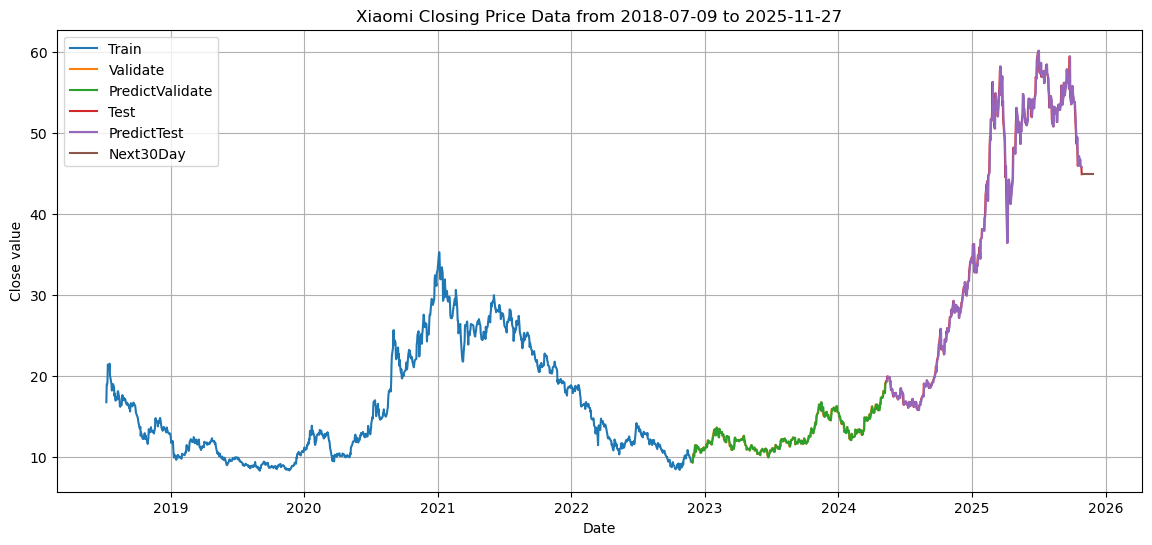

In [13]:
# Cell 13 - Combined Visualization: Train / Validate / PredictValidate / Test / PredictTest / Next30Day

# Recreate series for plotting (original scale)
train_true = scaler.inverse_transform(train_data.reshape(-1,1)).reshape(-1)
val_true = scaler.inverse_transform(val_data.reshape(-1,1)).reshape(-1)
test_true = scaler.inverse_transform(test_data.reshape(-1,1)).reshape(-1)

# best_y_pred_val (already inverse transformed earlier) -> ensure array
pred_val_plot = np.array(best_y_pred_val).reshape(-1)
pred_test_plot = y_pred_test_inv  # inverse transformed earlier

plt.figure(figsize=(14,6))

# plot Train
plt.plot(df_close.index[:train_size], train_true, label='Train')

# plot Validate (actual)
plt.plot(df_close.index[train_size: train_size + val_size], val_true, label='Validate')

# plot Predict on Validate
plt.plot(df_close.index[train_size: train_size + val_size], pred_val_plot, label='PredictValidate')

# plot Test (actual)
plt.plot(df_close.index[train_size + val_size :], test_true, label='Test')

# plot Predict on Test
plt.plot(df_close.index[train_size + val_size :], pred_test_plot, label='PredictTest')

# plot Next30Days forecast
plt.plot(index_next_30_days, y_next_30_inv, label='Next30Day')

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Day'])
plt.grid()
plt.title(f"Xiaomi Closing Price Data from {df_close.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig("Xiaomi_SES_Visualization.png", dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Cell 14 - Save summary and next-30 forecasts
summary_df = pd.DataFrame({
    'phase': ['validation_best', 'test'],
    'mse': [best_mse, test_mse],
    'mape': [best_mape, test_mape],
    'rmse': [best_rmse, test_rmse],
    'msle': [best_msle, test_msle],
    'best_alpha': [best_alpha, best_alpha]
})
summary_df.to_csv('Xiaomi_SES_summary.csv', index=False)

forecast_df = pd.DataFrame({
    'date': index_next_30_days,
    'forecast_close': y_next_30_inv
})
forecast_df.to_csv('Xiaomi_SES_forecast30.csv', index=False)

print("Saved Xiaomi_SES_summary.csv and Xiaomi_SES_forecast30.csv")


Saved Xiaomi_SES_summary.csv and Xiaomi_SES_forecast30.csv


In [15]:
# Cell 15 - Display final summary and a quick peek at 30-day forecast
print("Summary metrics:")
display(summary_df)

print("\nFirst 10 of 30-day forecast:")
display(forecast_df.head(10))


Summary metrics:


,phase,mse,mape,rmse,msle,best_alpha
0,validation_best,0.067191,0.013343,0.259211,0.000332,1.0
1,test,0.759333,0.014260,0.871397,0.000423,1.0



First 10 of 30-day forecast:


,date,forecast_close
0,2025-10-29,44.919998
1,2025-10-30,44.919998
2,2025-10-31,44.919998
3,2025-11-01,44.919998
4,2025-11-02,44.919998
5,2025-11-03,44.919998
6,2025-11-04,44.919998
7,2025-11-05,44.919998
8,2025-11-06,44.919998
9,2025-11-07,44.919998
